In [ ]:
import clr
import os
import sys
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pythonnet
base_path = '/Users/MTinti/git_projects/RawFileReader'

In [ ]:
!pip freeze

adjustText @ file:///home/conda/feedstock_root/build_artifacts/adjusttext_1705321634488/work
altair @ file:///home/conda/feedstock_root/build_artifacts/altair_1701735522225/work
anyio @ file:///opt/concourse/worker/volumes/live/eb44598f-565b-45e7-4c50-c1ae70306e18/volume/anyio_1644481722202/work/dist
appdirs==1.4.4
appnope @ file:///Users/builder/ci_310/appnope_1642500616005/work
argcomplete @ file:///tmp/build/80754af9/argcomplete_1618920853202/work
argh==0.26.2
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///opt/concourse/worker/volumes/live/cf502f86-3f51-4f85-686b-4867f6d672bd/volume/argon2-cffi-bindings_1644569704808/work
asciitree==0.3.3
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
beautifulsoup4 @ fi

In [ ]:
clr.AddReference(os.path.join(base_path, 'Libs/Net471/ThermoFisher.CommonCore.Data.dll'))
clr.AddReference(os.path.join(base_path, 'Libs/Net471/ThermoFisher.CommonCore.RawFileReader.dll'))
clr.AddReference(os.path.join(base_path, 'Libs/Net471/ThermoFisher.CommonCore.BackgroundSubtraction.dll'))
clr.AddReference(os.path.join(base_path, 'Libs/Net471/ThermoFisher.CommonCore.MassPrecisionEstimator.dll'))

<System.Reflection.RuntimeAssembly object>

In [ ]:
#ls ../RawFileReader/Libs/Net471/ThermoFisher.CommonCore.Data.dll

In [ ]:
# Continue with the rest of your script imports
from System import *
from System.Collections.Generic import *
from ThermoFisher.CommonCore.Data import ToleranceUnits, Extensions
from ThermoFisher.CommonCore.Data.Business import ChromatogramSignal, ChromatogramTraceSettings
from ThermoFisher.CommonCore.Data.Business import DataUnits, Device, GenericDataTypes, SampleType, Scan, TraceType
from ThermoFisher.CommonCore.Data.FilterEnums import IonizationModeType, MSOrderType
from ThermoFisher.CommonCore.Data.Interfaces import IChromatogramSettings, IScanEventBase, IScanFilter, RawFileClassification
from ThermoFisher.CommonCore.MassPrecisionEstimator import PrecisionEstimate
from ThermoFisher.CommonCore.RawFileReader import RawFileReaderAdapter


In [ ]:
def ReadScanInformation(rawFile, firstScanNumber, lastScanNumber):
    time_ms, current_ms, ms_type = [], [], []
    #time_ms2, current_ms2 = [], []
    for scanIndex, scan in enumerate(tqdm(range(firstScanNumber, lastScanNumber))):
        time = rawFile.RetentionTimeFromScanNumber(scan)
        scanFilter = IScanFilter(rawFile.GetFilterForScanNumber(scan))

        # Common operations for both MS1 and MS2
        scanStatistics = rawFile.GetScanStatsForScanNumber(scan)
        segmentedScan = rawFile.GetSegmentedScanFromScanNumber(scan, scanStatistics)
        total_current = np.sum(segmentedScan.Intensities)

        time_ms.append(time)
        current_ms.append(total_current)
        ms_type.append(scanFilter.MSOrder)

    return time_ms, current_ms, ms_type


def plot_ms_cycle_time_and_total_current(df, out_path, instrument_name=None):

    # Set up the plot layout
    fig, axes = plt.subplots(figsize=(16, 8), ncols=2, nrows=2)
    axes = axes.flatten()

    # Filter the DataFrame for MS1 and MS2 data and calculate cycle times
    ms1 = df[df['MS'] == 'Ms'].copy()
    ms1.loc[:, 'cycle_time'] = ms1['RT'] - ms1['RT'].shift(1)

    ms2 = df[df['MS'] == 'Ms2'].copy()
    ms2.loc[:, 'cycle_time'] = ms2['RT'] - ms2['RT'].shift(1)

    # Plot cycle time by RT_bin for MS1 and MS2
    ms1.groupby('RT_bin')['cycle_time'].mean().reset_index().plot(kind='line', x='RT_bin', y='cycle_time', ax=axes[0], label='MS1')
    ms2.groupby('RT_bin')['cycle_time'].mean().reset_index().plot(kind='line', x='RT_bin', y='cycle_time', ax=axes[1], label='MS2')

    # Plot total current by RT_bin for MS1 and MS2
    ms1.groupby('RT_bin')['total_current'].mean().reset_index().plot(kind='line', x='RT_bin', y='total_current', ax=axes[2], label='MS1')
    ms2.groupby('RT_bin')['total_current'].mean().reset_index().plot(kind='line', x='RT_bin', y='total_current', ax=axes[3], label='MS2')

    # Optionally print the instrument name if provided
    if instrument_name:
        plt.title('Instrument name: {}'.format(instrument_name))
    plt.tight_layout()
    plt.savefig(os.path.join(out_path+'.png'))

startTime 1.006635593001048 endTime: 11.00968669118881 RAW file


100%|█████████████████████████████████████| 4073/4073 [00:00<00:00, 4356.03it/s]


Analysing raw file from Orbitrap Exploris Slot #10103
All done


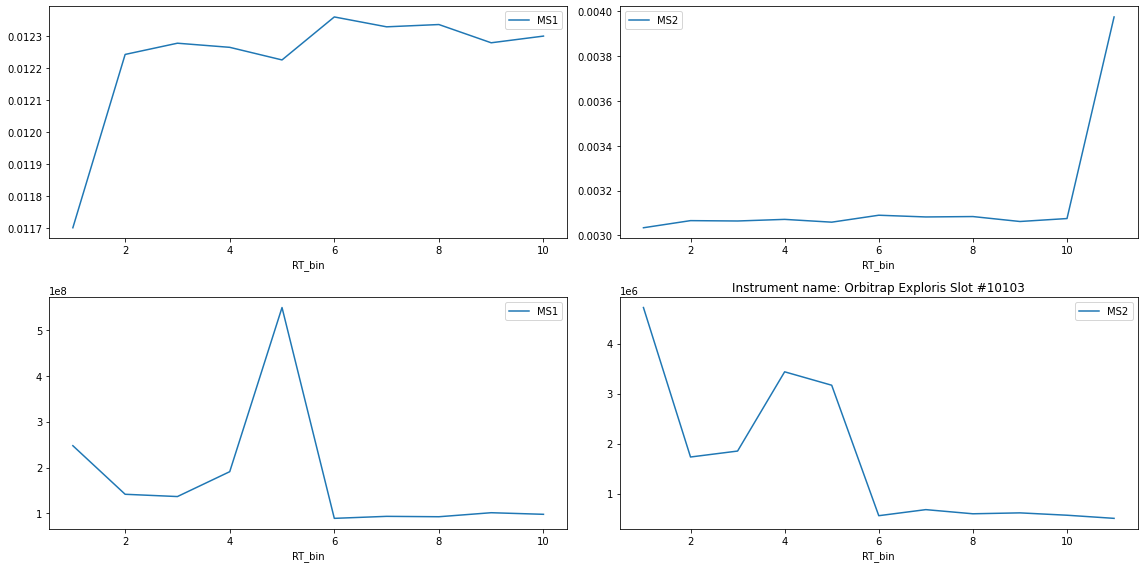

In [ ]:
if __name__ == '__main__':
    # The first argument after the script name is the path to the RAW file
    raw_file_path = '/Users/MTinti/git_projects/rawQC/QC3.raw' #sys.argv[1]


    rawFile = RawFileReaderAdapter.FileFactory(raw_file_path)
    rawFile.SelectInstrument(Device.MS, 1)

    firstScanNumber = rawFile.RunHeaderEx.FirstSpectrum
    lastScanNumber = rawFile.RunHeaderEx.LastSpectrum

    startTime = rawFile.RunHeaderEx.StartTime
    endTime = rawFile.RunHeaderEx.EndTime
    print('startTime', startTime, 'endTime:', endTime, 'RAW file')
    time_list = ReadScanInformation(rawFile, firstScanNumber, lastScanNumber)
    
    df = pd.DataFrame()
    df['RT']=time_list[0]
    df['total_current']=time_list[1]
    df['MS']=time_list[2]
    df['MS']=df['MS'].astype(str)
    df['RT_bin']=df['RT'].astype(int)

    instrument_name = rawFile.GetInstrumentData().Name
    print('Analysing raw file from', instrument_name)
    plot_ms_cycle_time_and_total_current(df, raw_file_path, instrument_name=instrument_name)
    print('All done')